# RNN, LSTM, GRU의 주가 예측 모델의 성능 비교 테스트

In [4]:
import pandas as pd

df = pd.read_csv("../dataset/AAPL_2006-01-01_to_2018-01-01.csv")

df.head(5)

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


In [8]:
sample_x = df["Close"]
sample_y = df["Date"]

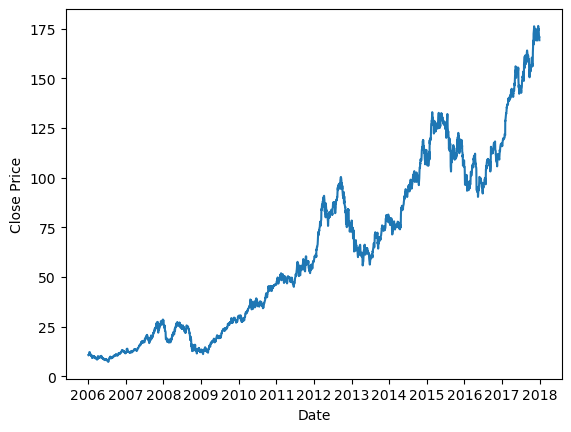

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
from datetime import datetime

date = []

for row in sample_y:
    date.append(matplotlib.dates.date2num(datetime.strptime(row, '%Y-%m-%d')))

plt.plot(date, sample_x.to_numpy())
plt.xlabel("Date")
plt.ylabel("Close Price")

ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
plt.show()

In [176]:
def show_stock_graph(prices):
    plt.plot(date, prices)
    plt.xlabel("Date")
    plt.ylabel("Close Price")

    ax = plt.gca()
    ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
    plt.show()

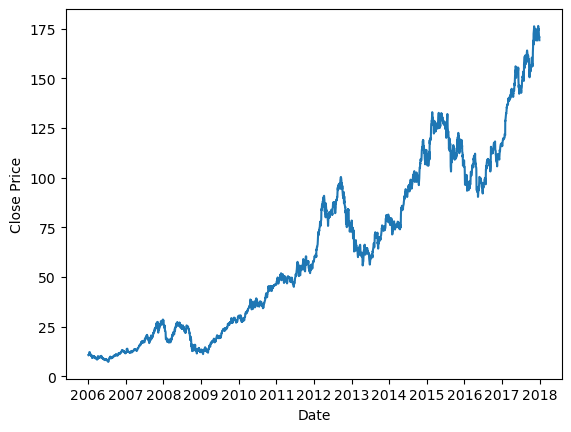

In [177]:
show_stock_graph(sample_x.to_numpy())

## 1. 종가만 가지고 예측을 진행하기

In [178]:
import numpy as np

def split_data(stock, lookback):
    data_row = stock.to_numpy()
    data = []

    for index in range(len(data_row) - lookback):
        data.append(data_row[index:index+lookback])
    
    data = np.array(data)

    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - test_set_size

    x_train = data[:train_set_size, :-1]
    y_train = data[:train_set_size, -1]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1]

    return [x_train, y_train, x_test, y_test]


In [198]:
lookback = 20
price = df["Close"]
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [199]:
x_train[:3], y_train[:3]

(array([[10.68, 10.71, 10.63, 10.9 , 10.86, 11.55, 11.99, 12.04, 12.23,
         12.1 , 11.78, 11.29, 10.87, 11.1 , 10.86, 10.6 , 10.33, 10.29,
         10.71],
        [10.71, 10.63, 10.9 , 10.86, 11.55, 11.99, 12.04, 12.23, 12.1 ,
         11.78, 11.29, 10.87, 11.1 , 10.86, 10.6 , 10.33, 10.29, 10.71,
         10.79],
        [10.63, 10.9 , 10.86, 11.55, 11.99, 12.04, 12.23, 12.1 , 11.78,
         11.29, 10.87, 11.1 , 10.86, 10.6 , 10.33, 10.29, 10.71, 10.79,
         10.77]]),
 array([10.79, 10.77, 10.3 ]))

In [200]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_rnn = torch.from_numpy(y_train).type(torch.Tensor)
y_test_rnn = torch.from_numpy(y_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [201]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [213]:
from torchsummary import summary as summary_

class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, state_ = self.rnn(x)
        print(out.shape, out[:, -1, :].shape)
        out = self.fc(out[:,-1, :])
        print(out.shape)
        return out


model = RNN(input_dim, hidden_dim, num_layers, output_dim)
summary_(model,(19,1),batch_size=10)

torch.Size([2, 19, 32]) torch.Size([2, 32])
torch.Size([2, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 19, 32], [-1, 2, 32]]               0
            Linear-2                    [10, 1]              33
Total params: 33
Trainable params: 33
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 0.00
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


In [214]:
import torch.optim as optim

model = RNN(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [215]:
# x_train = x_train.squeeze(0)
# print(x_train.shape)
x_train_rnn = x_train.unsqueeze(2)
print(x_train_rnn.shape)

y_train_rnn_ = y_train_rnn.unsqueeze(1)
print(y_train_rnn_.shape)


torch.Size([2399, 19, 1])
torch.Size([2399, 1])


In [216]:
x = torch.FloatTensor(1, 19, 1)
print(x)
model(x)

tensor([[[2.4140e-08],
         [8.5900e-43],
         [2.4128e-08],
         [8.5900e-43],
         [2.4128e-08],
         [8.5900e-43],
         [2.4129e-08],
         [8.5900e-43],
         [2.4131e-08],
         [8.5900e-43],
         [2.4131e-08],
         [8.5900e-43],
         [2.4131e-08],
         [8.5900e-43],
         [2.4133e-08],
         [8.5900e-43],
         [2.4134e-08],
         [8.5900e-43],
         [2.4134e-08]]])
torch.Size([1, 19, 32]) torch.Size([1, 32])
torch.Size([1, 2])


tensor([[-0.0376,  0.2497]], grad_fn=<AddmmBackward0>)

In [205]:
import matplotlib.gridspec as gridspec

hist = []

for epoch in range(num_epochs):
    y_train_pred = model(x_train_rnn)

    optimizer.zero_grad()
    loss = criterion(y_train_pred, y_train_rnn_)
    print(f"Epoch: [{epoch}/{num_epochs}] | Loss: {loss.item()}")
    
    hist.append(loss.item())

    loss.backward()
    optimizer.step()


torch.Size([2399, 2])
Epoch: [0/100] | Loss: 3622.784912109375
torch.Size([2399, 2])
Epoch: [1/100] | Loss: 3580.990478515625
torch.Size([2399, 2])
Epoch: [2/100] | Loss: 3542.098388671875
torch.Size([2399, 2])
Epoch: [3/100] | Loss: 3506.183837890625
torch.Size([2399, 2])
Epoch: [4/100] | Loss: 3472.16943359375
torch.Size([2399, 2])
Epoch: [5/100] | Loss: 3441.734619140625
torch.Size([2399, 2])
Epoch: [6/100] | Loss: 3412.2314453125
torch.Size([2399, 2])
Epoch: [7/100] | Loss: 3382.88623046875
torch.Size([2399, 2])
Epoch: [8/100] | Loss: 3353.57275390625


c:\Users\YSH\anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2399, 1])) that is different to the input size (torch.Size([2399, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([2399, 2])
Epoch: [9/100] | Loss: 3324.43017578125
torch.Size([2399, 2])
Epoch: [10/100] | Loss: 3295.923583984375
torch.Size([2399, 2])
Epoch: [11/100] | Loss: 3268.52294921875
torch.Size([2399, 2])
Epoch: [12/100] | Loss: 3241.408935546875
torch.Size([2399, 2])
Epoch: [13/100] | Loss: 3213.86376953125
torch.Size([2399, 2])
Epoch: [14/100] | Loss: 3185.9521484375
torch.Size([2399, 2])
Epoch: [15/100] | Loss: 3157.8798828125
torch.Size([2399, 2])
Epoch: [16/100] | Loss: 3129.801025390625
torch.Size([2399, 2])
Epoch: [17/100] | Loss: 3101.785888671875
torch.Size([2399, 2])
Epoch: [18/100] | Loss: 3073.884765625
torch.Size([2399, 2])
Epoch: [19/100] | Loss: 3046.22998046875
torch.Size([2399, 2])
Epoch: [20/100] | Loss: 3018.958740234375
torch.Size([2399, 2])
Epoch: [21/100] | Loss: 2992.094482421875
torch.Size([2399, 2])
Epoch: [22/100] | Loss: 2965.583984375
torch.Size([2399, 2])
Epoch: [23/100] | Loss: 2939.361328125
torch.Size([2399, 2])
Epoch: [24/100] | Loss: 2913.3825683

In [206]:
def show_history(hist, y, y_pred):
    fig = plt.figure() 

    gs = gridspec.GridSpec(1, 2)

    ax1 = plt.subplot(gs[0,0])
    ax1.plot(y)
    ax1.plot(y_pred)
    ax1.legend()

    # ax1.xlabel("Date")
    # ax1.ylabel("Price") 

    #x_range = np.arange(hist.shape[0])
    ax2 = plt.subplot(gs[0, 1])
    ax2.plot(range(len(hist)), hist)
    # ax2.xlabel("Epoch")
    # ax2.ylabel("Training Loss")

    plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


torch.Size([2399, 2])
tensor([[22.8599, 23.5153],
        [22.8813, 23.5382],
        [22.8769, 23.5333],
        ...,
        [28.6890, 30.0218],
        [28.6890, 30.0218],
        [28.6890, 30.0218]], grad_fn=<AddmmBackward0>)


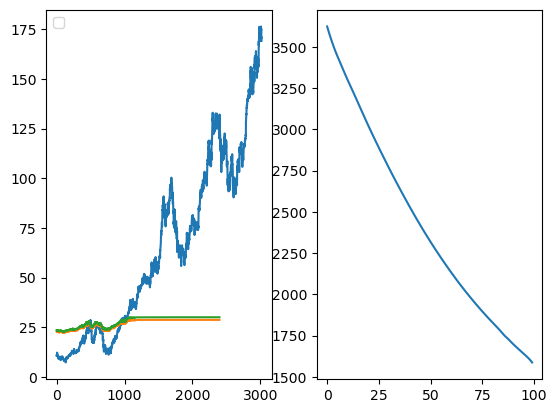

In [207]:

y_finally_pred = model(x_train_rnn)

print(y_finally_pred)

show_history(hist, price.to_numpy(), y_finally_pred.detach().numpy())